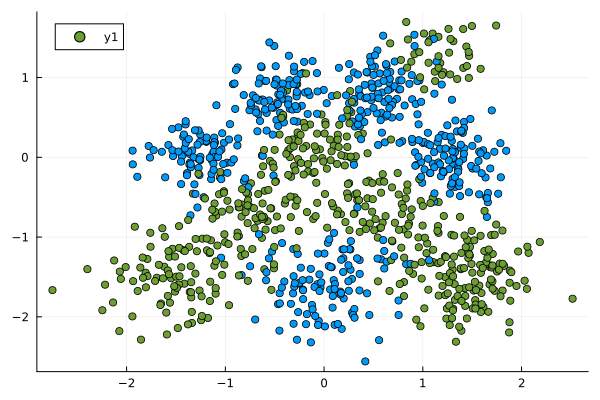

In [1]:
using DataFrames, CSV, DelimitedFiles
using Plots
using Zygote
using ForwardDiff

X = [ones(1000, 1) readdlm("X.txt", ' ', Float64)] 
y = readdlm("y.txt", ' ', Int64) 

scatter(X[:, 2], X[:, 3], markercolor=y)

## Regression

Model using:

$$ y = w^T X + b + \epsilon_n$$

where:

$$ \epsilon_n \sim \mathcal{N}(0, \sigma^2) $$

by adding a third dimension to X, as done above, we can use:

$$ y = w^T \tilde{X} + \epsilon_n$$

Ultimately we have:

$$ p(y_n | \tilde{\mathbf{x}}_n, \mathbf{\theta}) = \mathcal{N}(y_n | \mathbf{w}^t \tilde{\mathbf{x}}_n, \sigma^2) $$



## Logistic Regression

$$\begin{align*}
 p(y_n | \tilde{\mathbf{x}}_n, \mathbf{\theta}) &= y_n \sigma (\mathbf{w}^T \tilde{\mathbf{x}}_n) + (1 - y_n) (1 - \sigma (\mathbf{w}^T \tilde{\mathbf{x}}_n))\\
&= y_n \sigma (\mathbf{w}^T \tilde{\mathbf{x}}_n) + (1 - y_n)  \sigma (-\mathbf{w}^T \tilde{\mathbf{x}}_n)\\
\end{align*}$$


In [2]:
logistic(X) = 1 / (1 + exp(-clamp.(X, -1000, 1000)))

likelihood(X, y, w) = y .* logistic.(X * w) .+ (1 .- y) .* logistic.(-X * w)

log_loss(X, y, w) = sum(log.(likelihood(X, y, w)))

log_loss (generic function with 1 method)

-1335.8203757430924


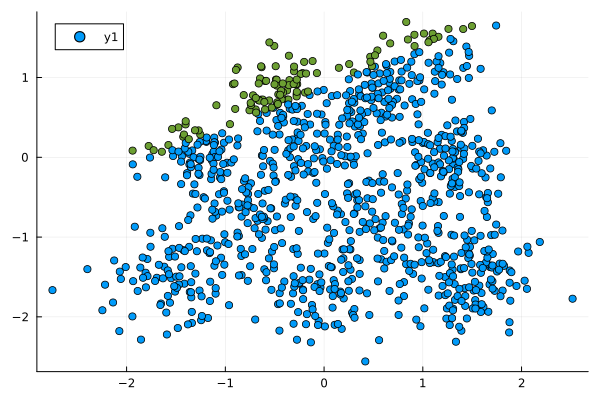

In [3]:
w = randn(3, 1)
predictions = logistic.(X * w)
binary_pred = predictions .|> (x -> x < 0.5 ? 0 : 1)

println(log_loss(X, y, w))
scatter(X[:, 2], X[:, 3], markercolor=binary_pred)


In [43]:
# Gradient ascent
function train(Input, labels; lr=0.001, epochs=50_000)
    n_features = size(Input, 2)
    params = randn(n_features, 1) .* 0.001 # Initialize weights
    println("Initial log likelihood = $(log_loss(Input, labels, params))")
    
    for i in 1:epochs
        lr = lr * 0.9999  # Decrease learning rate
        # Compute gradient using Zygote
        grad = Zygote.gradient(params -> log_loss(Input, labels, params), params)[1]

        # Update weights (ascent because we're maximizing)
        params .+= lr * grad

        # Print progress every 100 epochs
        if i % 10_000 == 0
            loss = log_loss(Input, labels, params)
            println("Epoch $i: log likelihood = $loss")
            
            
        end
    end
    println("Training complete.")
    println("Final log likelihood = $(log_loss(Input, labels, params))")
    return params
end

train (generic function with 1 method)

Initial log likelihood = -694.1977562844668
Epoch 10000: log likelihood = -623.4619710586629
Epoch 20000: log likelihood = -623.4619710586629
Training complete.
Final log likelihood = -623.4619710586629


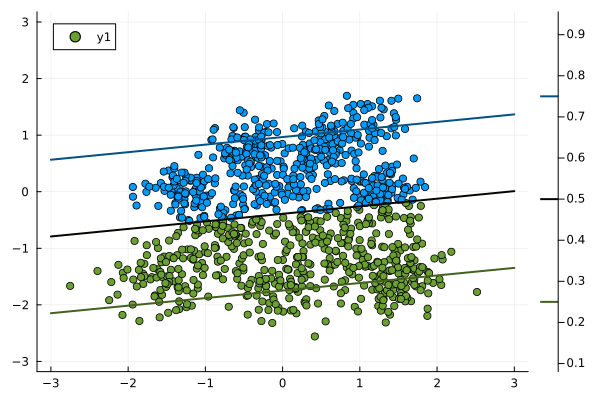

In [5]:
w_opt = train(X, y)
pred = logistic.(X * w_opt)
binary_pred = pred .|> (x -> x < 0.5 ? 0 : 1)

scatter(X[:, 2], X[:, 3], markercolor=binary_pred)
contour!(-3:0.01:3, -3:0.01:3, 
        (x, y) -> logistic.([1 x y] * w_opt)[1], 
        levels=[0.25,0.5,0.75], c=[0,:black,1], lw=2)


Initial log likelihood = -690.7525644015147
Epoch 10000: log likelihood = -1113.7775847910705
Epoch 20000: log likelihood = -557.6610756369979
Epoch 30000: log likelihood = -557.6610756369979
Epoch 40000: log likelihood = -557.6610756369979
Epoch 50000: log likelihood = -557.6610756369979
Training complete.
Final log likelihood = -557.6610756369979


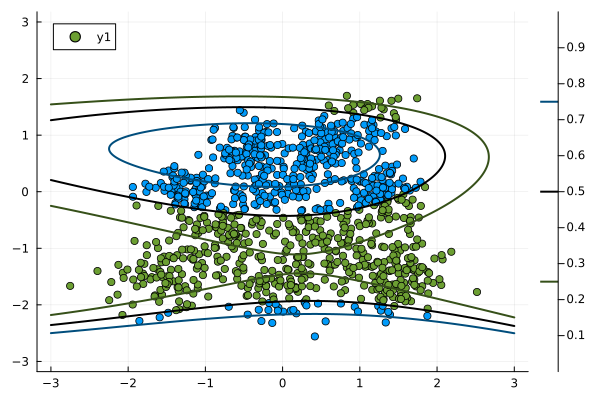

In [30]:
X_nl2 = [X X[:, 2].^2 X[:, 3].^2 X[:, 2].*X[:, 3]]
X_nl3 = [X_nl2 X[:, 2].^3 X[:, 3].^3]

w_opt_nl = train(X_nl3, y)
predictions = logistic.(X_nl3 * w_opt_nl)
binary_pred = predictions .|> (x -> x < 0.5 ? 0 : 1)

scatter(X[:, 2], X[:, 3], markercolor=binary_pred)
contour!(-3:0.01:3, -3:0.01:3, 
         (x, y) -> logistic.([1 x y x*x y*y x*y x*x*x y*y*y] * w_opt_nl)[1], 
         levels=[0.25,0.5,0.75], c=[0,:black,1], lw=2)

## Basis Functions

Expanding on the above result, we look at other basis functions that better capture non-inearities further from the origin


$$ s(X, center_m, width) = \frac{\sqrt{(X - center_m)' (X - center_m)}}{width} $$


In [26]:
function sigmoidal_basis(X, centers, width)
    n_samples, n_features = size(X)
    n_centers = size(centers, 1)
    basis = zeros(n_samples, n_centers)
    
    for i in 1:n_samples
        for j in 1:n_centers
            basis[i, j] = logistic(sqrt(sum((X[i, :] .- centers[j, :]).^2)) / width)
        end
    end
    
    return basis
end

sigmoidal_basis (generic function with 1 method)

Initial log likelihood = -693.1661884009304
Epoch 10000: log likelihood = -612.9509016422962
Epoch 20000: log likelihood = -589.6958277049187
Epoch 30000: log likelihood = -585.3923734266999
Epoch 40000: log likelihood = -583.9687559371716
Epoch 50000: log likelihood = -583.4597644289045
Training complete.
Final log likelihood = -583.4597644289045


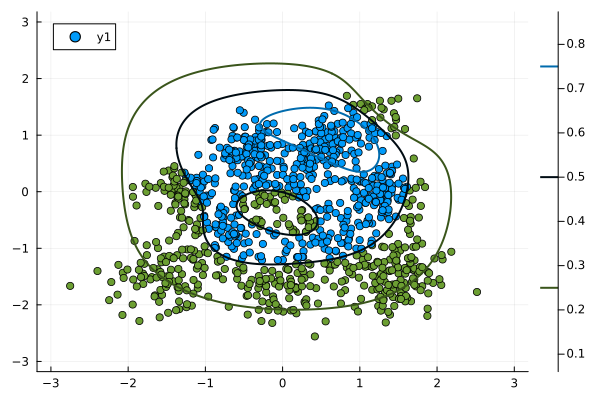

In [44]:

centers = randn(24, 6) .- collect(range(-5, 5, length=24))
width = 1.0
X_basis = sigmoidal_basis(X_nl2, centers, width)

w_opt_basis = train(X_basis, y)
predictions = logistic.(X_basis * w_opt_basis)
binary_pred = predictions .|> (x -> x < 0.5 ? 0 : 1)

scatter(X[:, 2], X[:, 3], markercolor=binary_pred)
contour!(-3:0.01:3, -3:0.01:3, 
         (x, y) -> logistic.(sigmoidal_basis([1 x y x*x y*y x*y], centers, width) * w_opt_basis)[1], 
         levels=[0.25,0.5,0.75], c=[0,:black,1], lw=2)